In [68]:
#Install PMArima
!pip install pmdarima

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels


In [ ]:
##Import Libraries 

In [70]:
#Import libraries for Spark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark import SparkContext


In [71]:
import os

java_home = os.environ.get('JAVA_HOME')
if java_home:
    print("JAVA_HOME is set to:", java_home)
else:
    print("JAVA_HOME is not set.")

JAVA_HOME is set to: /usr/lib/jvm/default-java


In [72]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName('TruckSalesTimeSeries') \
    .config("spark.executor.memory", "2g") \
    .config("spark.driver.memory", "1g") \
    .config("spark.sql.shuffle.partitions", "100") \
    .getOrCreate()

In [73]:
#Load the CSV file into DataFrame
df = spark.read.csv('Truck_sales.csv',header=True,escape="\"")

In [74]:
# Display the top 5 rows of the DataFrame
df.show(5)

+----------+------------------+
|Month-Year|Number_Trucks_Sold|
+----------+------------------+
|    03-Jan|               155|
|    03-Feb|               173|
|    03-Mar|               204|
|    03-Apr|               219|
|    03-May|               223|
+----------+------------------+
only showing top 5 rows



In [ ]:
#Data Pre-processing and Exploratory Analysis 

In [77]:
# Count the number of rows
num_rows = df.count()

# Count the number of columns
num_columns = len(df.columns)

# Print the shape of the DataFrame
print(f"The dataframe has {num_rows} rows and {num_columns} columns")

The dataframe has 144 rows and 2 columns


In [80]:
# Convert Spark DataFrame to Pandas DataFrame
df_pandas = df.toPandas()

In [83]:
# Convert 'Month-Year' to datetime format
import pandas as pd
df_pandas['Month-Year'] = pd.to_datetime(df_pandas['Month-Year'], format='%y-%b')

# Set 'Month-Year' as the index
df_pandas.set_index('Month-Year', inplace=True)

In [92]:
df_pandas.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 2003-01-01 to 2014-12-01
Data columns (total 1 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Number_Trucks_Sold  144 non-null    object
dtypes: object(1)
memory usage: 2.2+ KB


In [101]:
#Check null values
null_counts = df_pandas.isnull().sum()
print(null_counts)

# Alternatively, to count total null values across the entire DataFrame
total_nulls = df_pandas.isnull().sum().sum()
print(f'Total null values in the DataFrame: {total_nulls}')


Number_Trucks_Sold    0
dtype: int64
Total null values in the DataFrame: 0


In [105]:
# Check for duplicates in the index (dates)
duplicates_in_index = df_pandas.index.duplicated()

# Count total duplicate dates
total_duplicates = duplicates_in_index.sum()
print(f'Total duplicate dates in the index: {total_duplicates}')

# Display the duplicated dates
if total_duplicates > 0:
    print("Duplicated dates:\n", df_pandas.index[duplicates_in_index])
else:
    print("No duplicate dates found in the index.")


Total duplicate dates in the index: 0
No duplicate dates found in the index.


In [93]:
# Convert 'Number_Trucks_Sold' to numeric values
df_pandas['Number_Trucks_Sold'] = pd.to_numeric(df_pandas['Number_Trucks_Sold'], errors='coerce')

# Drop any rows where 'Number_Trucks_Sold' could not be converted to numeric
df_pandas.dropna(subset=['Number_Trucks_Sold'], inplace=True)

# Convert the column to integers
df_pandas['Number_Trucks_Sold'] = df_pandas['Number_Trucks_Sold'].astype(int)

# Check the DataFrame info again to confirm the changes
print(df_pandas.info())



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 2003-01-01 to 2014-12-01
Data columns (total 1 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   Number_Trucks_Sold  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB
None


In [124]:
df_pandas.head()

,Number_Trucks_Sold,Month,Year
Month-Year,,,
2003-01-01,155,1,2003
2003-02-01,173,2,2003
2003-03-01,204,3,2003
2003-04-01,219,4,2003
2003-05-01,223,5,2003


<Figure size 1200x800 with 0 Axes>

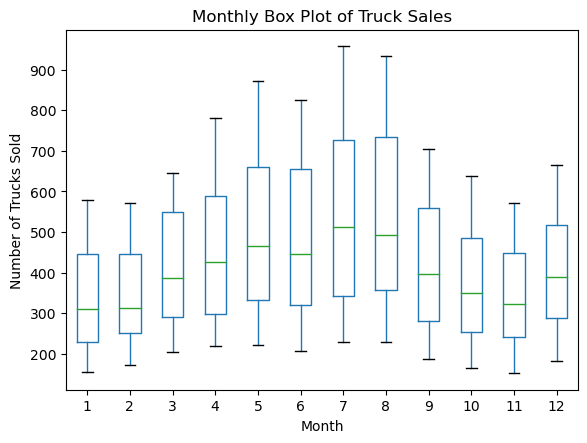

In [106]:
import matplotlib.pyplot as plt

# Ensure the index is in datetime format
df_pandas.index = pd.to_datetime(df_pandas.index)

# Extract the month from the index and add it as a new column
df_pandas['Month'] = df_pandas.index.month

# Create a box plot for each month
plt.figure(figsize=(12, 8))
df_pandas.boxplot(column='Number_Trucks_Sold', by='Month', grid=False)
plt.title('Monthly Box Plot of Truck Sales')
plt.suptitle('')  
plt.xlabel('Month')
plt.ylabel('Number of Trucks Sold')
plt.show()


<Figure size 1200x800 with 0 Axes>

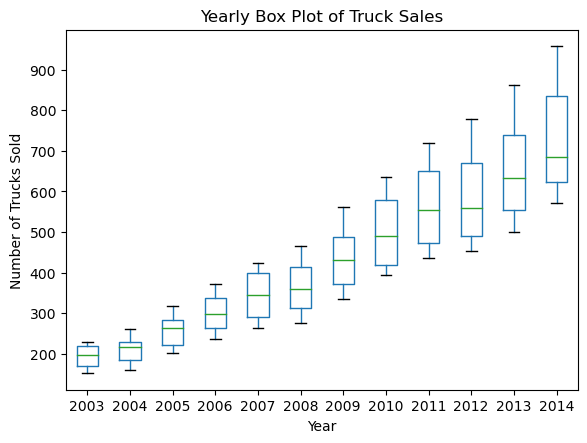

In [107]:
# Extract the year from the index and add it as a new column
df_pandas['Year'] = df_pandas.index.year

# Create a box plot for each year
plt.figure(figsize=(12, 8))
df_pandas.boxplot(column='Number_Trucks_Sold', by='Year', grid=False)
plt.title('Yearly Box Plot of Truck Sales')
plt.suptitle('')  # Suppress the default title to avoid overlapping
plt.xlabel('Year')
plt.ylabel('Number of Trucks Sold')
plt.show()


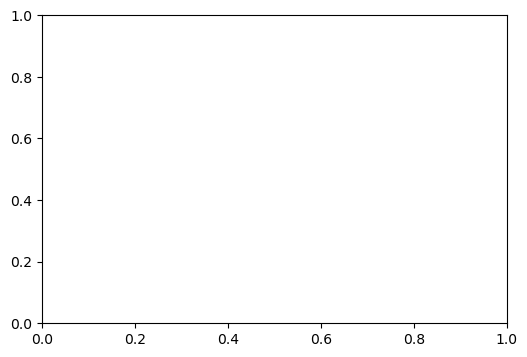

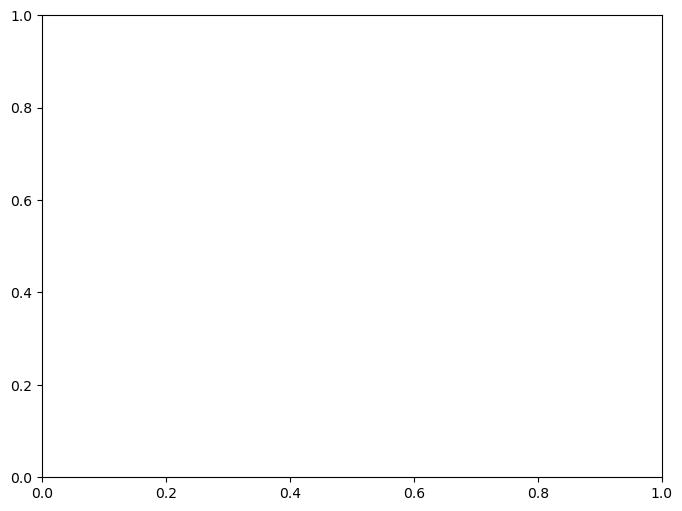

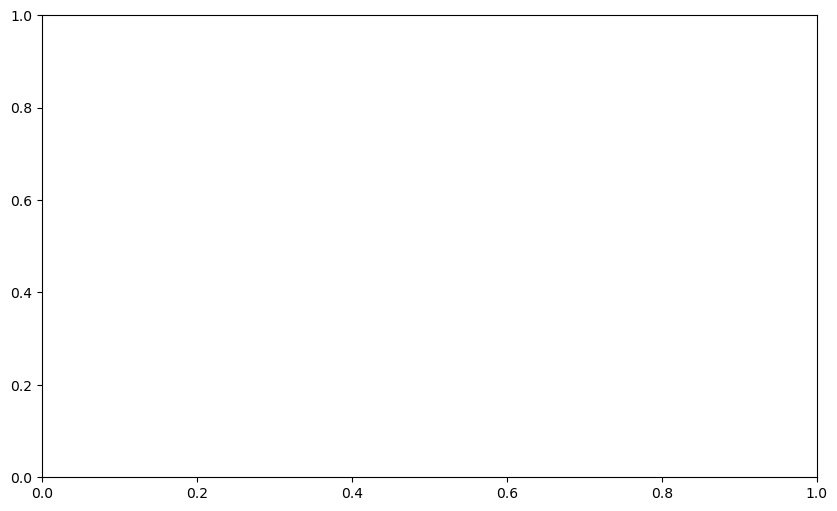

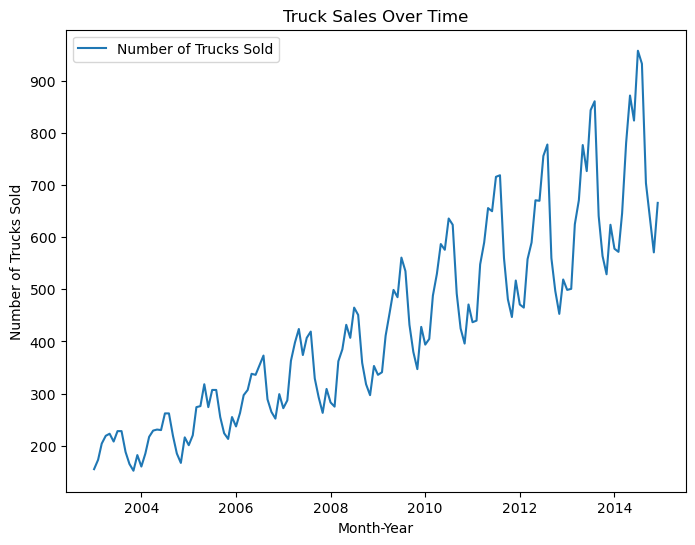

In [129]:
import matplotlib.pyplot as plt

# Plot the time series
plt.figure(figsize=(8, 6))
plt.plot(df_pandas['Number_Trucks_Sold'], label='Number of Trucks Sold')
plt.title('Truck Sales Over Time')
plt.xlabel('Month-Year')
plt.ylabel('Number of Trucks Sold')
plt.legend()
plt.show()

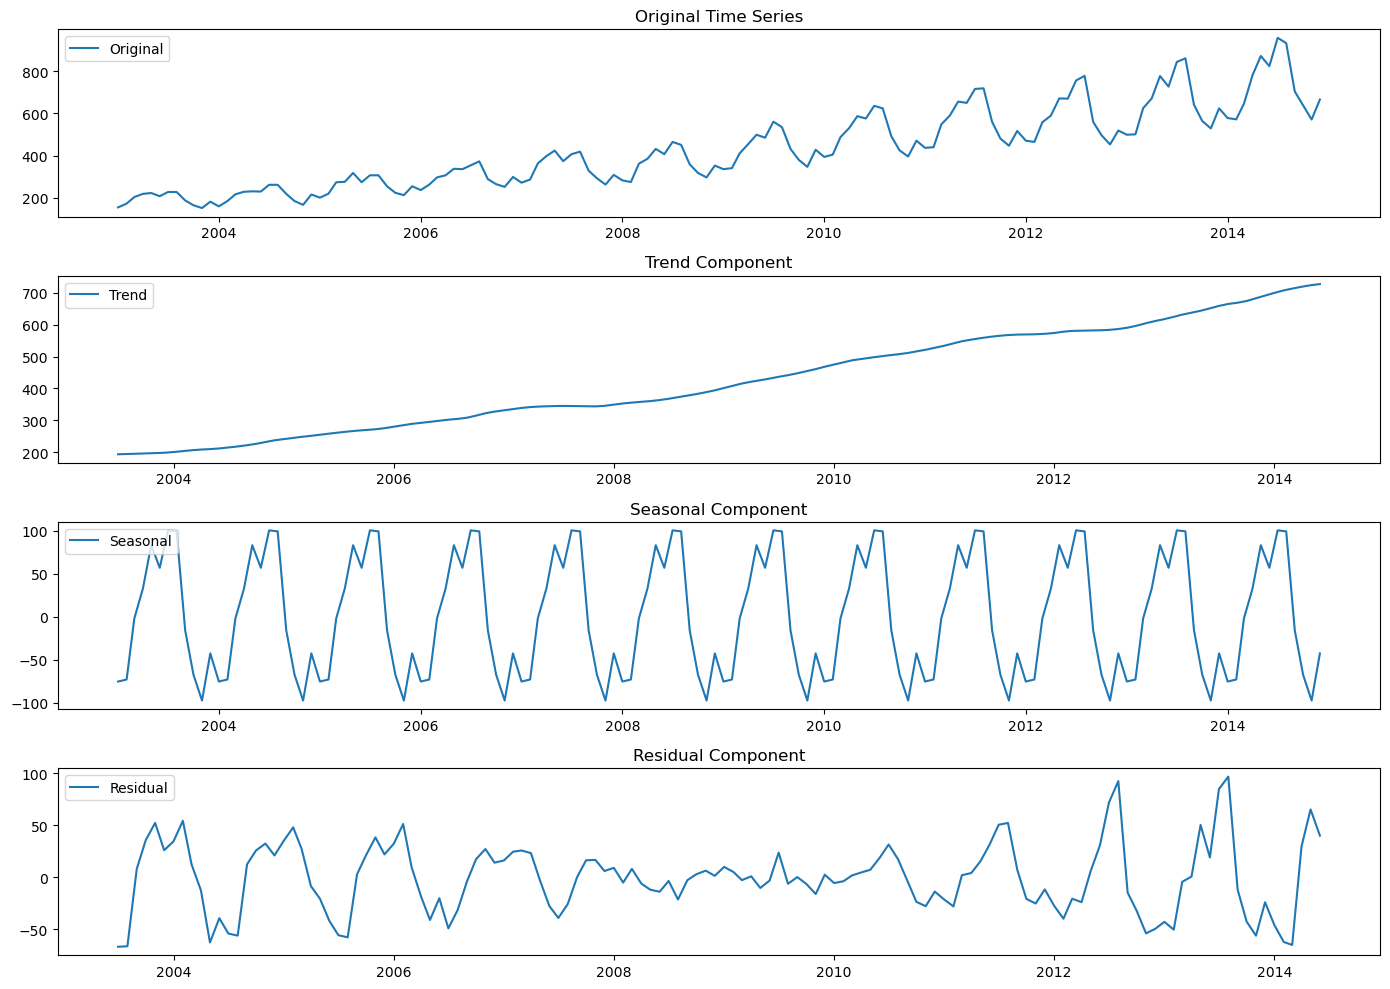

In [108]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming df_pandas is your DataFrame with datetime index and 'Number_Trucks_Sold' column

# Ensure the index is in datetime format
df_pandas.index = pd.to_datetime(df_pandas.index)

# Seasonal decomposition
# You can adjust the model to 'multiplicative' if your data exhibits multiplicative seasonality
decomposition = seasonal_decompose(df_pandas['Number_Trucks_Sold'], model='additive', period=12)  # Change period as needed

# Plot the decomposition
plt.figure(figsize=(14, 10))

plt.subplot(4, 1, 1)
plt.plot(df_pandas['Number_Trucks_Sold'], label='Original')
plt.legend(loc='upper left')
plt.title('Original Time Series')

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='upper left')
plt.title('Trend Component')

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.title('Seasonal Component')

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Residual')
plt.legend(loc='upper left')
plt.title('Residual Component')

plt.tight_layout()
plt.show()


In [113]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Seasonal decomposition
decomposition = seasonal_decompose(df_pandas['Number_Trucks_Sold'], model='additive', period=12)  # Assuming monthly data

# Extract the seasonal component
seasonal_component = decomposition.seasonal

# Print seasonal component values
print("Seasonal Component Values:\n", seasonal_component.head(12))  # Show values for the first 12 months


Seasonal Component Values:
 Month-Year
2003-01-01    -75.465593
2003-02-01    -73.083018
2003-03-01     -1.798927
2003-04-01     32.905619
2003-05-01     83.432134
2003-06-01     57.102588
2003-07-01    100.750316
2003-08-01     99.545770
2003-09-01    -15.730745
2003-10-01    -67.442866
2003-11-01    -97.575442
2003-12-01    -42.639836
Name: seasonal, dtype: float64


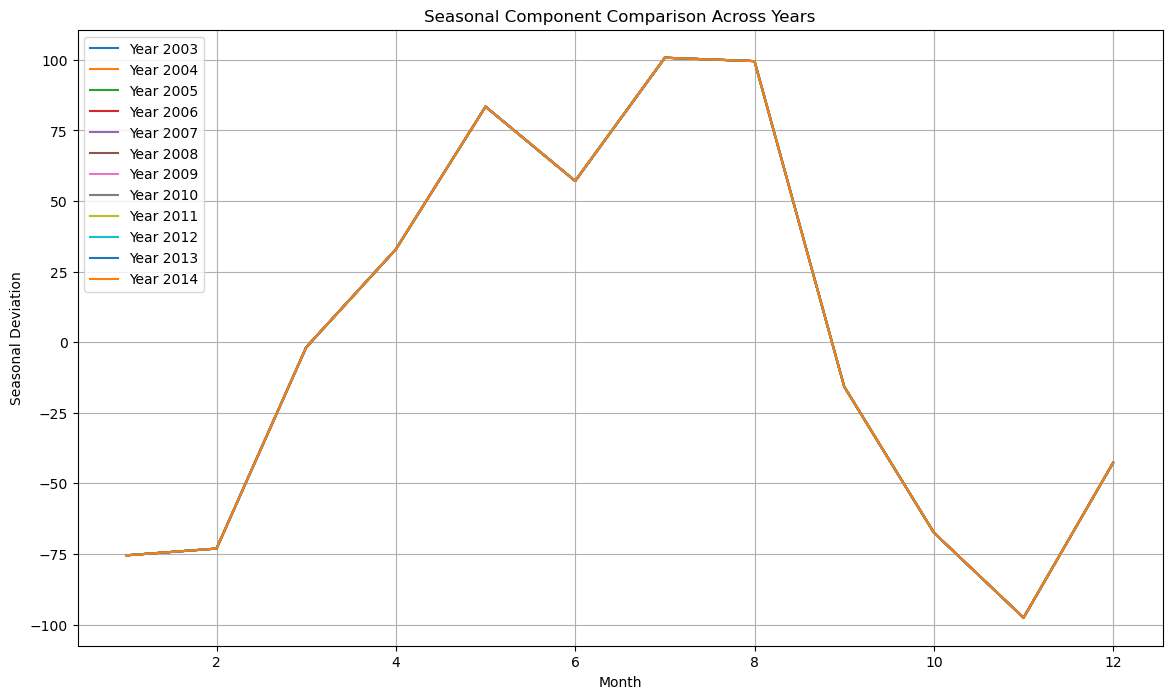

Year         2003        2004        2005        2006        2007        2008  \
Month                                                                           
1      -75.465593  -75.465593  -75.465593  -75.465593  -75.465593  -75.465593   
2      -73.083018  -73.083018  -73.083018  -73.083018  -73.083018  -73.083018   
3       -1.798927   -1.798927   -1.798927   -1.798927   -1.798927   -1.798927   
4       32.905619   32.905619   32.905619   32.905619   32.905619   32.905619   
5       83.432134   83.432134   83.432134   83.432134   83.432134   83.432134   
6       57.102588   57.102588   57.102588   57.102588   57.102588   57.102588   
7      100.750316  100.750316  100.750316  100.750316  100.750316  100.750316   
8       99.545770   99.545770   99.545770   99.545770   99.545770   99.545770   
9      -15.730745  -15.730745  -15.730745  -15.730745  -15.730745  -15.730745   
10     -67.442866  -67.442866  -67.442866  -67.442866  -67.442866  -67.442866   
11     -97.575442  -97.57544

In [114]:
#seasonal decompose 
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Ensure df_pandas is your DataFrame with datetime index and 'Number_Trucks_Sold' column
df_pandas.index = pd.to_datetime(df_pandas.index)

# Seasonal decomposition
decomposition = seasonal_decompose(df_pandas['Number_Trucks_Sold'], model='additive', period=12)  # Assuming monthly data

# Extract the seasonal component
seasonal_component = decomposition.seasonal

# Add month and year columns for comparison
df_pandas['Month'] = df_pandas.index.month
df_pandas['Year'] = df_pandas.index.year

# Combine seasonal component with original DataFrame
seasonal_df = df_pandas[['Month', 'Year']].copy()
seasonal_df['Seasonal Component'] = seasonal_component

# Pivot table to get average seasonal component by month across years
seasonal_comparison = seasonal_df.pivot_table(index='Month', columns='Year', values='Seasonal Component', aggfunc='mean')

# Plot seasonal components across years
plt.figure(figsize=(14, 8))
for year in seasonal_comparison.columns:
    plt.plot(seasonal_comparison.index, seasonal_comparison[year], label=f'Year {year}')

plt.title('Seasonal Component Comparison Across Years')
plt.xlabel('Month')
plt.ylabel('Seasonal Deviation')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Print the pivot table for reference
print(seasonal_comparison)


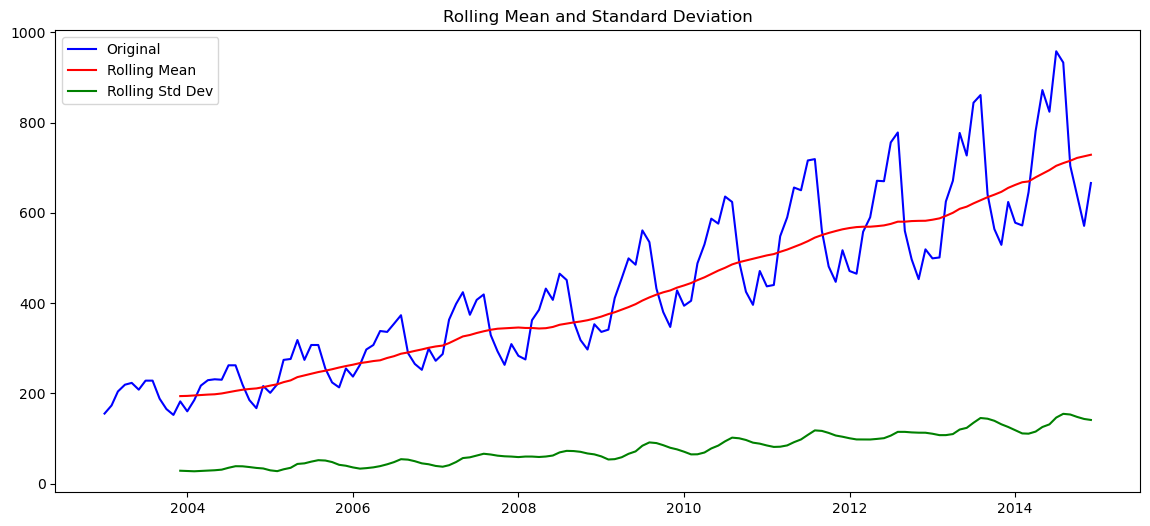

In [117]:
# Compute rolling mean and standard deviation
rolling_mean = df_pandas['Number_Trucks_Sold'].rolling(window=12).mean()
rolling_std = df_pandas['Number_Trucks_Sold'].rolling(window=12).std()

# Plot the rolling statistics
plt.figure(figsize=(14, 6))
plt.plot(df_pandas['Number_Trucks_Sold'], label='Original', color='blue')
plt.plot(rolling_mean, label='Rolling Mean', color='red')
plt.plot(rolling_std, label='Rolling Std Dev', color='green')
plt.legend(loc='upper left')
plt.title('Rolling Mean and Standard Deviation')
plt.show()


In [112]:
# Extract rolling mean and standard deviation values
rolling_mean_values = rolling_mean.dropna()
rolling_std_values = rolling_std.dropna()

# Print the first few values
print("Rolling Mean Values:\n", rolling_mean_values.head())
print("\nRolling Standard Deviation Values:\n", rolling_std_values.head())


Rolling Mean Values:
 Month-Year
2003-12-01    193.750000
2004-01-01    194.166667
2004-02-01    195.166667
2004-03-01    196.250000
2004-04-01    197.083333
Name: Number_Trucks_Sold, dtype: float64

Rolling Standard Deviation Values:
 Month-Year
2003-12-01    28.316796
2004-01-01    27.725385
2004-02-01    27.101940
2004-03-01    27.739453
2004-04-01    28.621220
Name: Number_Trucks_Sold, dtype: float64


In [96]:
#Test for stationarity
from statsmodels.tsa.stattools import adfuller

# Augmented Dickey-Fuller test for stationarity
result = adfuller(df_pandas['Number_Trucks_Sold'])

# Print the p-value
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: 1.1158932574252662
p-value: 0.9953500083802601
Critical Values: {'1%': -3.482087964046026, '5%': -2.8842185101614626, '10%': -2.578864381347275}


In [ ]:
#ADF Failed - data is non-stationary

In [ ]:
#Apply differencing

In [139]:
#Seasonal differencing is applied using monthly periods 
import pandas as pd

# Ensure the index is in datetime format
df_pandas.index = pd.to_datetime(df_pandas.index)

# Define the seasonal period
seasonal_period = 12

# Apply seasonal differencing
df_pandas['Seasonal_Diff'] = df_pandas['Number_Trucks_Sold'] - df_pandas['Number_Trucks_Sold'].shift(seasonal_period)

# Drop missing values created by differencing
df_pandas = df_pandas.dropna()

# Display the first few rows to inspect the results
print(df_pandas.head(5))


            Number_Trucks_Sold  Month  Year  Number_Trucks_Sold_Diff  \
Month-Year                                                             
2005-01-01                 201      1  2005                    -15.0   
2005-02-01                 220      2  2005                     19.0   
2005-03-01                 274      3  2005                     54.0   
2005-04-01                 276      4  2005                      2.0   
2005-05-01                 318      5  2005                     42.0   

            Seasonal_Diff  
Month-Year                 
2005-01-01           41.0  
2005-02-01           35.0  
2005-03-01           57.0  
2005-04-01           47.0  
2005-05-01           87.0  


/tmp/ipykernel_119/1555286049.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pandas['Seasonal_Diff'] = df_pandas['Number_Trucks_Sold'] - df_pandas['Number_Trucks_Sold'].shift(seasonal_period)


In [140]:
from statsmodels.tsa.stattools import adfuller

# Perform the ADF test again after seasonal differencing
result = adfuller(df_pandas['Seasonal_Diff'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])
#the results mean data acheives stationarity 

ADF Statistic: -3.3480454881577706
p-value: 0.012862761517950422
Critical Values: {'1%': -3.4870216863700767, '5%': -2.8863625166643136, '10%': -2.580009026141913}


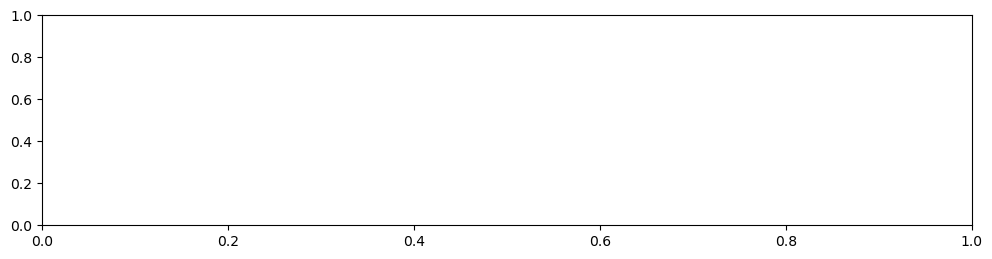

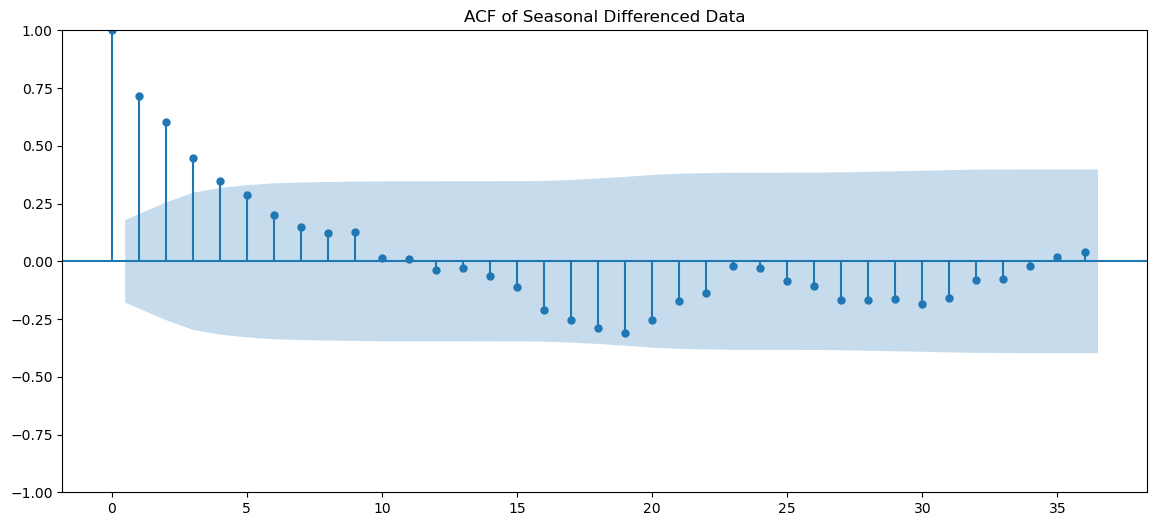

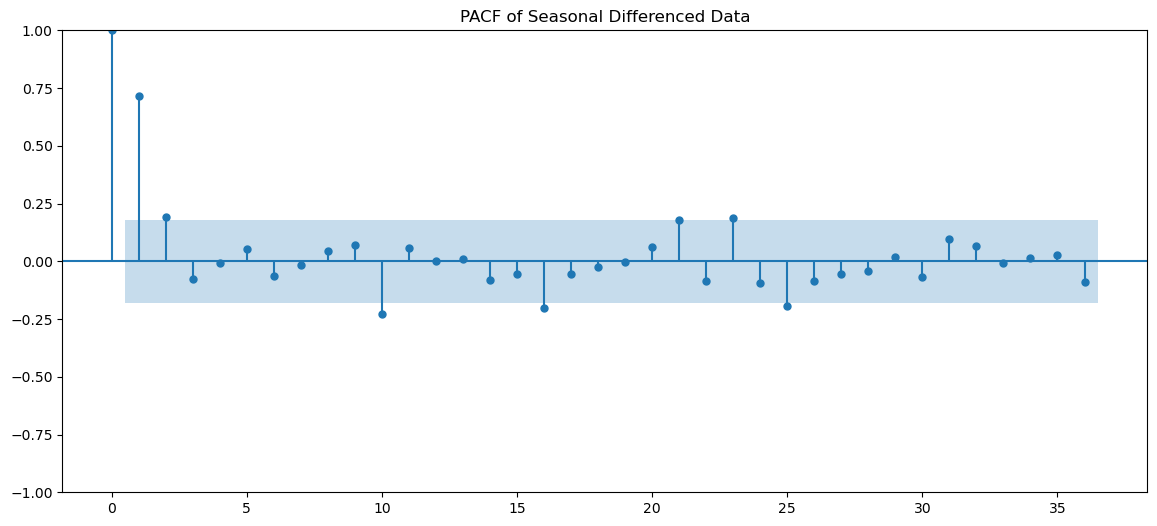

In [146]:
# Plot ACF
plt.figure(figsize=(14, 6))
plot_acf(df_pandas['Seasonal_Diff'], lags=36, ax=plt.gca(), title='ACF of Seasonal Differenced Data')
plt.show()

# Plot PACF
plt.figure(figsize=(14, 6))
plot_pacf(df_pandas['Seasonal_Diff'], lags=36, ax=plt.gca(), title='PACF of Seasonal Differenced Data')
plt.show()

In [148]:
import pmdarima as pm

# Fit AutoSARIMA model on the stationary data
model = pm.auto_arima(
    df_pandas['Seasonal_Diff'],
    seasonal=True,
    m=12,  # Seasonal period
    stepwise=True,
    trace=True
)

# Print the best model parameters
print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.98 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1139.170, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1057.070, Time=0.30 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1095.020, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1318.486, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=1056.108, Time=0.08 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=1057.230, Time=0.23 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=1053.595, Time=0.07 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=1054.960, Time=0.40 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=1055.111, Time=0.15 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.83 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : AIC=1054.668, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=1054.919, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept

In [149]:
# Split data into train and test sets using 80/20 split
train_size = int(len(df_pandas) * 0.8)  #  80% for training and 20% for testing
train, test = df_pandas['Number_Trucks_Sold'][:train_size], df_pandas['Number_Trucks_Sold'][train_size:]

In [154]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit the model on training data
model = SARIMAX(train, order=(2, 0, 0), seasonal_order=(0, 0, 0, 12))
model_fit = model.fit()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.46592D+00    |proj g|=  3.32063D-03

At iterate    5    f=  5.46589D+00    |proj g|=  5.70784D-03

At iterate   10    f=  5.46435D+00    |proj g|=  3.54939D-02

At iterate   15    f=  5.46369D+00    |proj g|=  2.94568D-03

At iterate   20    f=  5.46340D+00    |proj g|=  4.40808D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     25      1     0     0   7.215D-06   5.463D+00
  F =   5.4633901768684465     

CONVERG

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


In [176]:
# Forecast the next 72 periods ( 3 years)
forecast = model_fit.get_forecast(steps=72)
forecast_mean = forecast.predicted_mean

In [177]:
from sklearn.metrics import mean_squared_error

# Calculate MSE
mse = mean_squared_error(test, forecast_mean[:len(test)])
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 78221.3388361212


In [182]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Assuming 'forecast_mean' and 'test' are your forecasted and actual values, respectively

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(test, forecast_mean[:len(test)])
print(f'Mean Squared Error (MSE): {mse}')

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test, forecast_mean[:len(test)])
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((test - forecast_mean[:len(test)]) / test)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape}')

# Calculate R-squared (R²)
r_squared = r2_score(test, forecast_mean[:len(test)])
print(f'R-squared (R²): {r_squared}')


Mean Squared Error (MSE): 78221.3388361212
Root Mean Squared Error (RMSE): 279.68078024083314
Mean Absolute Error (MAE): 239.76859864636302
Mean Absolute Percentage Error (MAPE): 32.09814128498905
R-squared (R²): -3.434767129240905


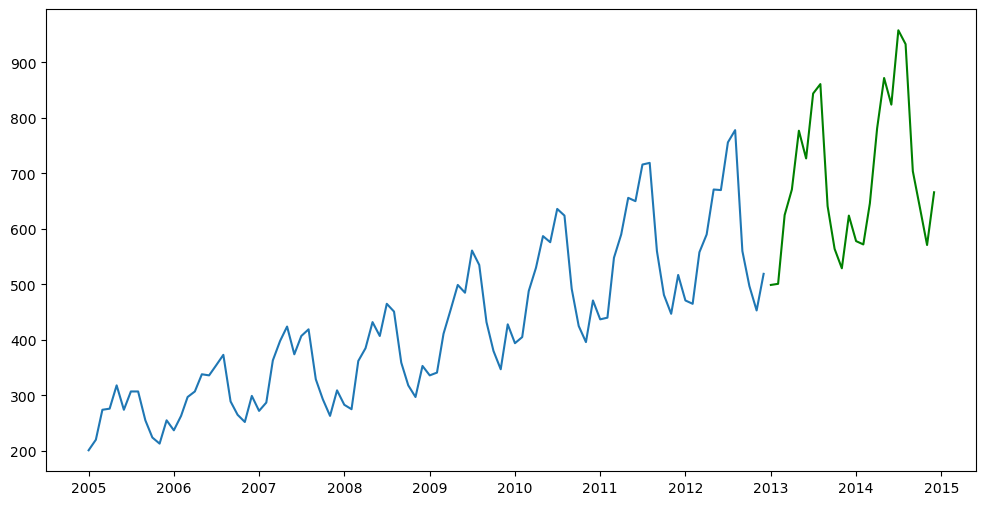

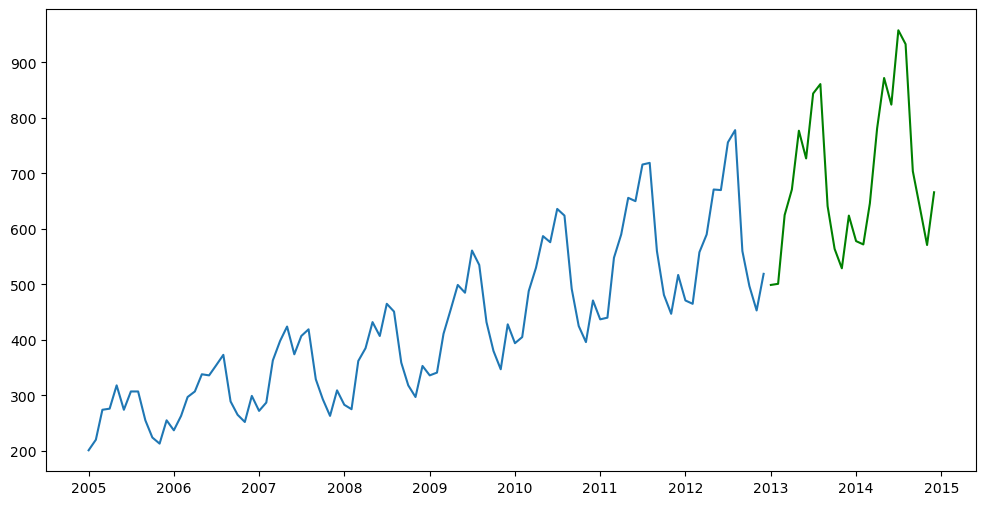

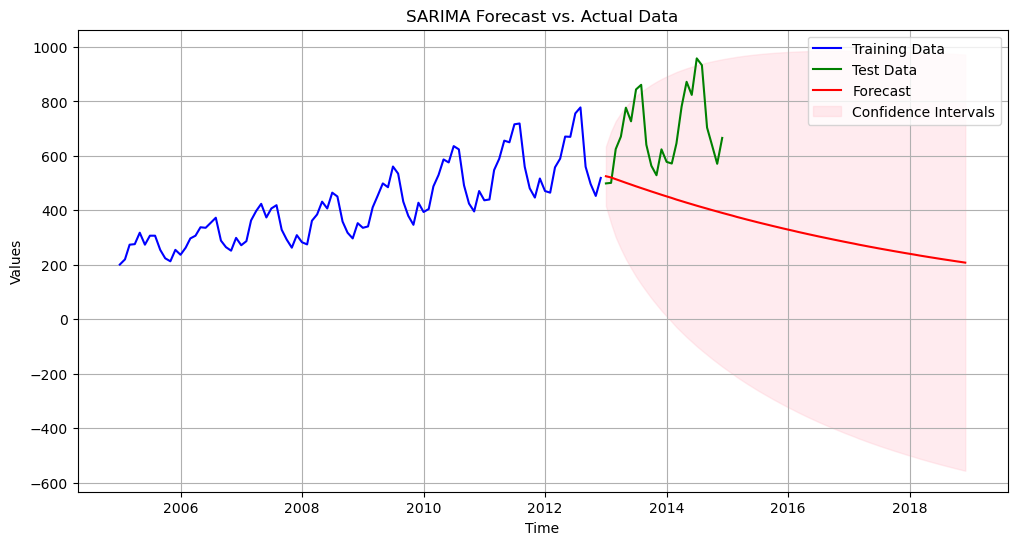

In [185]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data', color='blue')
plt.plot(test.index, test, label='Test Data', color='green')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='red')

# Add confidence intervals if needed
confidence_intervals = forecast.conf_int()
plt.fill_between(forecast_mean.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Intervals')

plt.title('SARIMA Forecast vs. Actual Data')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

